In [5]:
from dotenv import load_dotenv
from rich import print

load_dotenv()
%load_ext rich
%load_ext autoreload
%autoreload 2

## App

In [2]:
from youtube_lesson_planner.graph import create_graph

graph = create_graph()

In [3]:
response = graph.invoke({"original_query": "What is a function?"})

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'original_query': 'What is a function?'}
[0:writes] Finished step 0 with writes to 1 channel:
- original_query -> 'What is a function?'
[1:tasks] Starting step 1 with 1 task:
- make_vectorstore -> {'learning_objectives': None,
 'lesson_plan': None,
 'original_query': 'What is a function?',
 'rewritten_query': None,
 'transcripts_status': None,
 'vectorstore': None,
 'videos': None}
[1:writes] Finished step 1 with writes to 1 channel:
- vectorstore -> <langchain_qdrant.vectorstores.Qdrant object at 0x000001A768F46190>
[2:tasks] Starting step 2 with 1 task:
- objectives -> {'learning_objectives': None,
 'lesson_plan': None,
 'original_query': 'What is a function?',
 'rewritten_query': None,
 'transcripts_status': None,
 'vectorstore': <langchain_qdrant.vectorstores.Qdrant object at 0x000001A768F46190>,
 'videos': None}
[2:writes] Finished step 2 with writes to 1 channel:
- learning_objectives -> LearningObjectivesList(objectives=[Lea

In [6]:
response['lesson_plan']


LessonPlan(
    title='Understanding Functions in Programming',
    topics=[
        Topic(
            objective='Understand the definition and purpose of a function in programming.',
            videos=['zOjov-2OZ0E'],
            description='Learn what functions are and why they are essential in programming. This video will introduce the concept of functions, how they are used to encapsulate code, and the benefits they provide.',
            suggested_activities=[
                'Watch the video segment from 3600s to 3660s.',
                'Write a brief summary of what a function is in your own words.',
                'Discuss with peers in an online forum the importance of functions in programming.'
            ]
        ),
        Topic(
            objective='Identify the components of a function, including parameters and return values.',
            videos=['MjbuarJ7SE0'],
            description='Dive into the structure of a function, including its name, parameters, docs

## Flow

In [15]:
import json
from youtube_lesson_planner.video import YouTubeVideo

In [ ]:

embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=512)
qdrant_client = QdrantClient(
    location=":memory:",
)
qdrant_client.create_collection(
    "youtube_transcripts-1", {"size": 512, "distance": "Cosine"}
)

vectorstore = Qdrant(
    client=qdrant_client,
    collection_name="youtube_transcripts-1",
    embeddings=embeddings,
)

In [ ]:
with open(
    "../search_data/search_results_QLoRA quantization machine learning tutorial.json",
    "r",
) as f:
    items = json.load(f)["items"]

yt_videos = {
    item["id"]["videoId"]: YouTubeVideo(
        video_id=item["id"]["videoId"],
        title=item["snippet"]["title"],
        description=item["snippet"]["description"],
        published_at=item["snippet"]["publishedAt"],
        channel_title=item["snippet"]["channelTitle"],
        chunk_time_limit=30,
    )
    for item in items
}

In [ ]:
get_transcripts(list(yt_videos.values()), vectorstore)

In [ ]:
response = generate_learning_objectives("how to learn spanish")

In [ ]:
response

In [ ]:
query = rewrite("how to learn spanish", response)

In [ ]:
query

In [ ]:
videos = search_youtube(query.optimized_query)

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import Qdrant
from qdrant_client import QdrantClient

embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1536)
qdrant_client = QdrantClient(
    location=":memory:",
)
qdrant_client.create_collection("youtube_transcripts", {"size": 1536, "distance": "Cosine"})

In [ ]:
vectorstore = Qdrant(
    client=qdrant_client,
    collection_name="youtube_transcripts",
    embeddings=embeddings,
)

In [ ]:
transcripts = get_transcripts(videos, vectorstore)

In [ ]:
transcripts

In [ ]:
lesson_plan = generate_plan("how to learn spanish", response, vectorstore)

In [ ]:
lesson_plan

## LangGraph

In [6]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import Qdrant
from langgraph.graph import END, StateGraph
from qdrant_client import QdrantClient


In [7]:
from youtube_lesson_planner.nodes.generate_plan import generate_plan
from youtube_lesson_planner.nodes.get_transcripts import get_transcripts
from youtube_lesson_planner.nodes.learning_objectives import (
    generate_learning_objectives,
)
from youtube_lesson_planner.nodes.query_rewriter import rewrite
from youtube_lesson_planner.nodes.search_videos import search_youtube
from youtube_lesson_planner.schemas import AgentState


In [8]:
def create_vectorstore(state: AgentState) -> AgentState:
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1536)
    qdrant_client = QdrantClient(
        location=":memory:",
    )
    qdrant_client.create_collection(
        "youtube_transcripts", {"size": 1536, "distance": "Cosine"}
    )

    vectorstore = Qdrant(
        client=qdrant_client,
        collection_name="youtube_transcripts",
        embeddings=embeddings,
    )

    return {
        "vectorstore": vectorstore,
    }


In [9]:
def learning_objectives(state: AgentState) -> AgentState:
    query = state["original_query"]

    objectives = generate_learning_objectives(query)

    return {
        "learning_objectives": objectives,
    }


In [10]:
def rewrite_query(state: AgentState) -> AgentState:
    query = state["original_query"]
    objectives = state["learning_objectives"]

    rewritten_query = rewrite(query, objectives)

    return {
        "rewritten_query": rewritten_query.optimized_query,
    }


In [11]:
def search(state: AgentState) -> AgentState:
    optimized_query = state["rewritten_query"]
    videos = search_youtube(optimized_query, max_results=10)

    return {
        "videos": videos,
    }


In [12]:
def transcripts(state: AgentState) -> AgentState:
    videos = state["videos"]
    vectorstore = state["vectorstore"]

    _ = get_transcripts(list(videos.values()), vectorstore)

    return {"transcripts_status": True}

In [13]:
def generate(state: AgentState) -> AgentState:
    query = state["original_query"]
    objectives = state["learning_objectives"]
    vectorstore = state["vectorstore"]

    lesson_plan = generate_plan(query, objectives, vectorstore)

    return {
        "lesson_plan": lesson_plan,
    }


In [14]:
workflow = StateGraph(AgentState)


workflow.add_node("make_vectorstore", create_vectorstore)
workflow.add_node("objectives", learning_objectives)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("search", search)
workflow.add_node("transcripts", transcripts)
workflow.add_node("generate", generate)

workflow.set_entry_point("make_vectorstore")

workflow.add_edge("make_vectorstore", "objectives")
workflow.add_edge("objectives", "rewrite_query")
workflow.add_edge("rewrite_query", "search")
workflow.add_edge("search", "transcripts")
workflow.add_edge("transcripts", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile(debug=True)


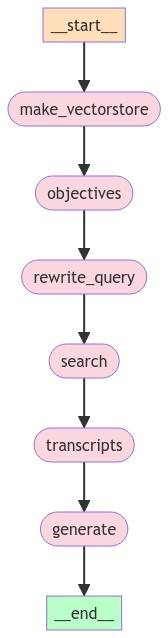

In [15]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [1]:
response = graph.invoke({"original_query": "build a house in fortnite"})

NameError: name 'graph' is not defined

In [44]:
response['lesson_plan']


LessonPlan(
    title='Building a House in Fortnite',
    topics=[
        Topic(
            objective='Understand the basic building mechanics and controls in Fortnite',
            videos=[
                Fortnite for Beginners: What Should You Learn First? by Billy Bicep - z0wnM20Noi8 | Live on Twitch: https://twitch.tv/Billy_Bicep Thanks for using code “billy-bicep” in the item shop Want a Fortnite Coach? Join my ...,
                5 Fortnite Battle Royale Building Tips by SXVXN - djha41CuxOE | Fortnite Battle Royale Building Tips. This video is all about the best 5 Beginner Fortnite Battle Royale Building Tips. In this video ...
            ],
            description='This topic covers the essential building mechanics and controls in Fortnite, including how to place walls, floors, ramps, and roofs. It will help learners get comfortable with the basic building tools and commands.',
            suggested_activities=[
                'Watch the provided videos to understand the 